In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU Device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
!git clone https://github.com/seshuad/IMagenet

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 31.65 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Updating files: 100% (120206/120206), done.


In [ ]:
!ls IMagenet/tiny-imagenet-200

test  train  val  wnids.txt  words.txt


In [ ]:
!ls IMagenet/tiny-imagenet-200/train

n01443537  n02113799  n02509815  n02988304  n03670208  n04146614  n04596742
n01629819  n02123045  n02666196  n02999410  n03706229  n04149813  n04597913
n01641577  n02123394  n02669723  n03014705  n03733131  n04179913  n06596364
n01644900  n02124075  n02699494  n03026506  n03763968  n04251144  n07579787
n01698640  n02125311  n02730930  n03042490  n03770439  n04254777  n07583066
n01742172  n02129165  n02769748  n03085013  n03796401  n04259630  n07614500
n01768244  n02132136  n02788148  n03089624  n03804744  n04265275  n07615774
n01770393  n02165456  n02791270  n03100240  n03814639  n04275548  n07695742
n01774384  n02190166  n02793495  n03126707  n03837869  n04285008  n07711569
n01774750  n02206856  n02795169  n03160309  n03838899  n04311004  n07715103
n01784675  n02226429  n02802426  n03179701  n03854065  n04328186  n07720875
n01855672  n02231487  n02808440  n03201208  n03891332  n04356056  n07734744
n01882714  n02233338  n02814533  n03250847  n03902125  n04366367  n07747607
n01910747  n

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
import os
from keras.callbacks import ModelCheckpoint

In [ ]:
 # Define image size and batch size
TARGET_SIZE = (299, 299)
BATCH_SIZE = 32

# Define data generators for train and validation data
train_dir = 'IMagenet/tiny-imagenet-200/train'
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   shear_range=0.2, 
                                   zoom_range=0.2, 
                                   horizontal_flip=True, 
                                   vertical_flip=False,
                                   validation_split=0.2)

train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=TARGET_SIZE, 
                                                    batch_size=BATCH_SIZE, 
                                                    class_mode='categorical',
                                                    subset='training')

val_generator = train_datagen.flow_from_directory(train_dir, 
                                                  target_size=TARGET_SIZE, 
                                                  batch_size=BATCH_SIZE, 
                                                  class_mode='categorical',
                                                  subset='validation')

Found 80000 images belonging to 200 classes.
Found 20000 images belonging to 200 classes.


In [ ]:
# Load Inception V3 pre-trained on ImageNet and remove top layer
base_model = InceptionV3(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, None, None,   96         ['conv2d[0][0]']                 
 alization)                     32)                                                           

                                                                                                  
 average_pooling2d (AveragePool  (None, None, None,   0          ['max_pooling2d_1[0][0]']        
 ing2D)                         192)                                                              
                                                                                                  
 conv2d_5 (Conv2D)              (None, None, None,   12288       ['max_pooling2d_1[0][0]']        
                                64)                                                               
                                                                                                  
 conv2d_7 (Conv2D)              (None, None, None,   76800       ['activation_6[0][0]']           
                                64)                                                               
                                                                                                  
 conv2d_10

                                                                                                  
 conv2d_18 (Conv2D)             (None, None, None,   16384       ['average_pooling2d_1[0][0]']    
                                64)                                                               
                                                                                                  
 batch_normalization_12 (BatchN  (None, None, None,   192        ['conv2d_12[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_normalization_14 (BatchN  (None, None, None,   192        ['conv2d_14[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 batch_nor

                                                                                                  
 batch_normalization_25 (BatchN  (None, None, None,   192        ['conv2d_25[0][0]']              
 ormalization)                  64)                                                               
                                                                                                  
 activation_19 (Activation)     (None, None, None,   0           ['batch_normalization_19[0][0]'] 
                                64)                                                               
                                                                                                  
 activation_21 (Activation)     (None, None, None,   0           ['batch_normalization_21[0][0]'] 
                                64)                                                               
                                                                                                  
 activatio

                                128)                                                              
                                                                                                  
 conv2d_36 (Conv2D)             (None, None, None,   114688      ['activation_35[0][0]']          
                                128)                                                              
                                                                                                  
 batch_normalization_31 (BatchN  (None, None, None,   384        ['conv2d_31[0][0]']              
 ormalization)                  128)                                                              
                                                                                                  
 batch_normalization_36 (BatchN  (None, None, None,   384        ['conv2d_36[0][0]']              
 ormalization)                  128)                                                              
          

 ormalization)                  160)                                                              
                                                                                                  
 activation_44 (Activation)     (None, None, None,   0           ['batch_normalization_44[0][0]'] 
                                160)                                                              
                                                                                                  
 conv2d_45 (Conv2D)             (None, None, None,   179200      ['activation_44[0][0]']          
                                160)                                                              
                                                                                                  
 batch_normalization_45 (BatchN  (None, None, None,   480        ['conv2d_45[0][0]']              
 ormalization)                  160)                                                              
          

 activation_48 (Activation)     (None, None, None,   0           ['batch_normalization_48[0][0]'] 
                                192)                                                              
                                                                                                  
 activation_49 (Activation)     (None, None, None,   0           ['batch_normalization_49[0][0]'] 
                                192)                                                              
                                                                                                  
 mixed5 (Concatenate)           (None, None, None,   0           ['activation_40[0][0]',          
                                768)                              'activation_43[0][0]',          
                                                                  'activation_48[0][0]',          
                                                                  'activation_49[0][0]']          
          

 batch_normalization_53 (BatchN  (None, None, None,   576        ['conv2d_53[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_58 (BatchN  (None, None, None,   576        ['conv2d_58[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 batch_normalization_59 (BatchN  (None, None, None,   576        ['conv2d_59[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_50 (Activation)     (None, None, None,   0           ['batch_normalization_50[0][0]'] 
          

 conv2d_60 (Conv2D)             (None, None, None,   147456      ['mixed6[0][0]']                 
                                192)                                                              
                                                                                                  
 conv2d_63 (Conv2D)             (None, None, None,   258048      ['activation_62[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_68 (Conv2D)             (None, None, None,   258048      ['activation_67[0][0]']          
                                192)                                                              
                                                                                                  
 conv2d_69 (Conv2D)             (None, None, None,   147456      ['average_pooling2d_6[0][0]']    
          

 batch_normalization_71 (BatchN  (None, None, None,   960        ['conv2d_71[0][0]']              
 ormalization)                  320)                                                              
                                                                                                  
 batch_normalization_75 (BatchN  (None, None, None,   576        ['conv2d_75[0][0]']              
 ormalization)                  192)                                                              
                                                                                                  
 activation_71 (Activation)     (None, None, None,   0           ['batch_normalization_71[0][0]'] 
                                320)                                                              
                                                                                                  
 activation_75 (Activation)     (None, None, None,   0           ['batch_normalization_75[0][0]'] 
          

                                384)                                                              
                                                                                                  
 activation_79 (Activation)     (None, None, None,   0           ['batch_normalization_79[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_82 (Activation)     (None, None, None,   0           ['batch_normalization_82[0][0]'] 
                                384)                                                              
                                                                                                  
 activation_83 (Activation)     (None, None, None,   0           ['batch_normalization_83[0][0]'] 
                                384)                                                              
          

 ormalization)                  384)                                                              
                                                                                                  
 batch_normalization_92 (BatchN  (None, None, None,   1152       ['conv2d_92[0][0]']              
 ormalization)                  384)                                                              
                                                                                                  
 conv2d_93 (Conv2D)             (None, None, None,   393216      ['average_pooling2d_8[0][0]']    
                                192)                                                              
                                                                                                  
 batch_normalization_85 (BatchN  (None, None, None,   960        ['conv2d_85[0][0]']              
 ormalization)                  320)                                                              
          

In [ ]:
# Set up callbacks requirement (everything skipped except checkpoint; uses more memory)
lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), cooldown=0, patience=5, min_lr=0.5e-6)
early_stopper = EarlyStopping(min_delta=0.001, patience=10)
checkpoint = ModelCheckpoint("InceptionV3_TinyImageNet200.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto')

In [ ]:
# Train the model with train_generator and set the validation_split parameter
history = model.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=10,
                    validation_data=val_generator, 
                    validation_steps=len(val_generator),
                    callbacks=[checkpoint])

Epoch 1/10
2500/2500 [==============================] - ETA: 0s - loss: 2.2092 - accuracy: 0.5329
Epoch 1: loss improved from inf to 2.20923, saving model to InceptionV3_TinyImageNet200.hdf5
2500/2500 [==============================] - 2585s 1s/step - loss: 2.2092 - accuracy: 0.5329 - val_loss: 1.5582 - val_accuracy: 0.6252
Epoch 2/10
2500/2500 [==============================] - ETA: 0s - loss: 1.4488 - accuracy: 0.6425
Epoch 2: loss improved from 2.20923 to 1.44880, saving model to InceptionV3_TinyImageNet200.hdf5
2500/2500 [==============================] - 2691s 1s/step - loss: 1.4488 - accuracy: 0.6425 - val_loss: 1.4829 - val_accuracy: 0.6416
Epoch 3/10
2500/2500 [==============================] - ETA: 0s - loss: 1.3388 - accuracy: 0.6668
Epoch 3: loss improved from 1.44880 to 1.33879, saving model to InceptionV3_TinyImageNet200.hdf5
2500/2500 [==============================] - 2423s 969ms/step - loss: 1.3388 - accuracy: 0.6668 - val_loss: 1.4198 - val_accuracy: 0.6544
Epoch 4/10


In [ ]:
model.save("InceptionV3_TinyImageNet200.h5")

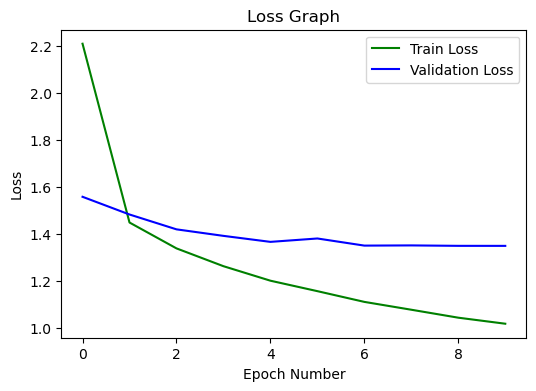

In [ ]:
plt.subplots(figsize=(6,4))
plt.plot(history.epoch,history.history["loss"],color="green",label="Train Loss")
plt.plot(history.epoch,history.history["val_loss"],color="blue",label="Validation Loss")
plt.xlabel("Epoch Number")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Graph")
plt.show()

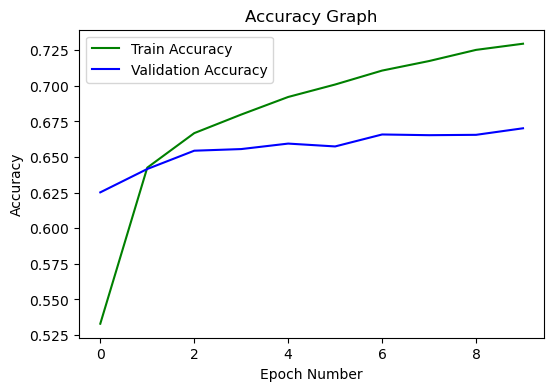

In [ ]:
plt.subplots(figsize=(6,4))
plt.plot(history.epoch,history.history["accuracy"],color="green",label="Train Accuracy")
plt.plot(history.epoch,history.history["val_accuracy"],color="blue",label="Validation Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Graph")
plt.show()

In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/InceptionV3/InceptionV3_TinyImageNet200.h5") # (must run this)

In [ ]:
# Separating validation images into separate sub folders to be used for testing
def create_val_img_folder():
    img_dir = os.path.join(val_dir, 'images')

    fp = open(os.path.join(val_dir, 'val_annotations.txt'), 'r')
    data = fp.readlines()
    val_img_dict = {}
    for line in data:
        words = line.split('\t')
        val_img_dict[words[0]] = words[1]
    fp.close()

    # Create folder if not present and move images into proper folders
    for img, folder in val_img_dict.items():
        newpath = (os.path.join(img_dir, folder))
        if not os.path.exists(newpath):
            os.makedirs(newpath)
        if os.path.exists(os.path.join(img_dir, img)):
            os.rename(os.path.join(img_dir, img), os.path.join(newpath, img))

val_dir = 'IMagenet/tiny-imagenet-200/val' # used as test dataset
create_val_img_folder()

In [ ]:
# Load the test data and labels
TARGET_SIZE = (299, 299)
val_dir = 'IMagenet/tiny-imagenet-200/val/images' # Newly arranged dataset according to its classes
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(val_dir,
                                                  target_size=TARGET_SIZE,
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)
test_labels = test_generator.classes
test_labels_2d = tf.keras.utils.to_categorical(test_labels, num_classes=200)

Found 10000 images belonging to 200 classes.


In [ ]:
# Evaluate the model against the test set
test_loss, test_acc = model.evaluate(test_generator, steps=len(test_generator))
print('Test accuracy:', test_acc)

10000/10000 [==============================] - 2771s 277ms/step - loss: 1.2493 - accuracy: 0.6940
Test accuracy: 0.6940000057220459


In [ ]:
# Get the predicted class probabilities for the test set
pred_probs = model.predict(test_generator, verbose=1)

# Get the predicted classes
pred_classes = np.argmax(pred_probs, axis=1)

# Find the indices of images that are correctly classified
correct_indices = np.where(pred_classes == test_labels)[0]

10000/10000 [==============================] - 190s 18ms/step


In [ ]:
# Save the correct_indices array to a file
np.savetxt('/content/drive/MyDrive/Colab Notebooks/InceptionV3/correct_indices.txt', correct_indices, fmt='%d')

In [ ]:
# Load the correct_indices array from a file
correct_indices = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/InceptionV3/correct_indices.txt', dtype=np.int32)

In [ ]:
# Randomly select 2500 images that are correctly classified
num_correct = len(correct_indices)
num_samples = 2500
if num_correct > num_samples:
    selected_indices = np.random.choice(correct_indices, size=num_samples, replace=False)
else:
    selected_indices = correct_indices
print("Number of correctly classified samples:", len(selected_indices))

Number of correctly classified samples: 2500


In [ ]:
# Get the images and labels corresponding to the selected indices
selected_images = []
selected_labels = []
for i in range(0, len(selected_indices), 50):
    batch_indices = selected_indices[i:i+50]
    batch_images, batch_labels = [], []
    for j in batch_indices:
        image, label = test_generator[j]
        batch_images.append(image)
        batch_labels.append(label)
    batch_images = np.concatenate(batch_images, axis=0)
    batch_labels = np.concatenate(batch_labels, axis=0)
    selected_images.append(batch_images)
    selected_labels.append(batch_labels)

selected_images = np.concatenate(selected_images, axis=0)
selected_labels = np.concatenate(selected_labels, axis=0)

print('Selected images shape:', selected_images.shape)
print('Selected labels shape:', selected_labels.shape)

# Save the selected images and labels
np.save('selected_images.npy', selected_images)
np.save('selected_labels.npy', selected_labels)

Selected images shape: (2500, 299, 299, 3)
Selected labels shape: (2500, 200)


In [ ]:
# Save the selected images and labels
np.save('/content/drive/MyDrive/Colab Notebooks/InceptionV3/selected_images.npy', selected_images)
np.save('/content/drive/MyDrive/Colab Notebooks/InceptionV3/selected_labels.npy', selected_labels)

In [ ]:
# Load the selected images and labels (must run this!)
import numpy as np
num_samples = 2500
selected_images = np.load('/content/drive/MyDrive/Colab Notebooks/InceptionV3/selected_images.npy')
selected_labels = np.load('/content/drive/MyDrive/Colab Notebooks/InceptionV3/selected_labels.npy')

print('Selected images shape:', selected_images.shape)
print('Selected labels shape:', selected_labels.shape)

Selected images shape: (2500, 299, 299, 3)
Selected labels shape: (2500, 200)


In [ ]:
# Make predictions on the selected images
selected_pred_probs = model.predict(selected_images)
selected_pred_classes = np.argmax(selected_pred_probs, axis=1)

# Calculate the accuracy of correctly classified images
selected_correct_indices = np.where(selected_pred_classes == np.argmax(selected_labels, axis=1))[0]
selected_num_correct = len(selected_correct_indices)
benign_accuracy = selected_num_correct / num_samples

print('Accuracy of benign images:', benign_accuracy)

79/79 [==============================] - 10s 120ms/step
Accuracy of benign images: 1.0


**Generating Adversarial Examples using Fast Gradient Sign Method (FGSM)** 

In [ ]:
# Define the FGSM attack function
def fgsm_attack(model, images, labels, eps, batch_size=50):
  
    adv_images = []
    num_batches = int(np.ceil(len(images) / batch_size))
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(images))
        batch_images = images[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]

        # Compute the gradient of the loss with respect to the input
        x_tensor = tf.convert_to_tensor(batch_images, dtype=tf.float32)
        # Record the gradient tape
        with tf.GradientTape() as tape:
            tape.watch(x_tensor)
            y_pred = model(x_tensor)
            loss_value = tf.keras.losses.categorical_crossentropy(batch_labels, 
                                                                  y_pred)
        gradient = tape.gradient(loss_value, x_tensor)

        # Generate the adversarial examples with FGSM
        adv_images_batch = batch_images + eps * tf.sign(gradient)
        adv_images_batch = tf.clip_by_value(adv_images_batch, 0, 1)
    
        # Compute the adversarial examples for the batch
        adv_images.extend(adv_images_batch.numpy())
    
    return adv_images

In [ ]:
# Generate adversarial examples using FGSM
eps = 0.1
adv_images = fgsm_attack(model, selected_images, selected_labels, eps, batch_size=50)

# Save the adversarial images to a numpy file
np.save('/content/drive/MyDrive/Colab Notebooks/InceptionV3/adv_images_fgsm.npy', adv_images)

# Evaluate the accuracy of the adversarial examples
adv_pred_probs = model.predict(np.array(adv_images))
adv_pred_classes = np.argmax(adv_pred_probs, axis=1)
adv_correct_indices = np.where(adv_pred_classes == np.argmax(selected_labels, axis=1))[0]
adv_num_correct = len(adv_correct_indices)
adv_accuracy = adv_num_correct / num_samples

print('Accuracy of adversarial examples:', adv_accuracy)

79/79 [==============================] - 5s 31ms/step
Accuracy of adversarial examples: 0.1496


**Defence against FGSM Attack**

In [ ]:
# Load the ifgsm adversarial images from the numpy file 
import numpy as np
adv_images = np.load('/content/drive/MyDrive/Colab Notebooks/InceptionV3/adv_images_fgsm.npy')

# Importing all files and libraries required
import tensorflow as tf
import numpy as np

model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/InceptionV3/InceptionV3_TinyImageNet200.h5") 

num_samples = 2500
selected_labels = np.load('/content/drive/MyDrive/Colab Notebooks/InceptionV3/selected_labels.npy')

In [ ]:
import cv2
from PIL import Image
from io import BytesIO
import datetime

# Perform fliplr on the adversarial images
x_fliplr = np.fliplr(adv_images)

for quality in [0, 25, 50, 75, 100]:
    print('--- For Quality Factor : {} ---'.format(quality))
    # Save the fliplr adversarial images and perform webp compression
    start_time = datetime.datetime.now()

    for i in range(num_samples):
        img = Image.fromarray(np.uint8(x_fliplr[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/fliplr_adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average time taken to save 1 fliplr adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))

    start_time = datetime.datetime.now()

    # Perform webp compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average time taken to save 1 original adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))

    start_time = datetime.datetime.now()
    
    # Perform jpg compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/adv_{}_{}.jpg'.format(i, quality), 'jpeg', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average Time taken to save 1 original adversarial image with jpg compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))
    
     # Load the fliplr adversarial images
    x_fliplr = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/fliplr_adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the fliplr adversarial examples
    y_pred = model.predict(x_fliplr)
    acc_fliplr = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with fliplr and webp compression:', acc_fliplr)

    # Load the webp compressed adversarial images
    x_webp = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the webp compressed adversarial examples
    y_pred = model.predict(x_webp)
    acc_webp = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with webp compression:', acc_webp)

    # Load the jpg compressed adversarial images
    x_jpg = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/adv_{}_{}.jpg'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the jpg compressed adversarial examples
    y_pred = model.predict(x_jpg)
    acc_jpg = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with jpeg compression:', acc_jpg)

--- For Quality Factor : 0 ---
Average time taken to save 1 fliplr adversarial image with webp compression: 0.0134 seconds
Average time taken to save 1 original adversarial image with webp compression: 0.0133 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0063 seconds
79/79 [==============================] - 2s 26ms/step
Accuracy on adversarial examples with fliplr and webp compression: 0.1508
79/79 [==============================] - 2s 26ms/step
Accuracy on adversarial examples with webp compression: 0.2484
79/79 [==============================] - 2s 26ms/step
Accuracy on adversarial examples with jpeg compression: 0.3012
--- For Quality Factor : 25 ---
Average time taken to save 1 fliplr adversarial image with webp compression: 0.0140 seconds
Average time taken to save 1 original adversarial image with webp compression: 0.0183 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0070 seconds
79/79 [==========

**Generating Adversarial Examples using Iterative Fast Gradient Sign Method (IFGSM)** 

In [ ]:
def ifgsm_batch(model, images, labels, eps=0.01, alpha=0.005, num_iter=10, batch_size=50):
    """
    Implements the iterative fast gradient sign method (IFGSM) attack on a given model.
    
    Args:
    - model: the target model to attack
    - images: a batch of input images to be attacked
    - labels: the true labels for the input images
    - eps: the maximum perturbation that can be added to each pixel (default: 0.01)
    - alpha: the step size for each iteration of the attack (default: 0.005)
    - num_iter: the number of iterations to run the attack (default: 10)
    - batch_size: the number of images to attack at once (default: 50)
    
    Returns:
    - adv_images: the adversarial images generated by the attack
    """
    adv_images = []
    num_batches = int(np.ceil(len(images) / batch_size))
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(images))
        batch_images = images[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]

        # Create a tensor from the batch images
        x = tf.convert_to_tensor(batch_images, dtype=tf.float32)

        # Iterate the FGSM attack
        for j in range(num_iter):
            with tf.GradientTape() as tape:
                tape.watch(x)
                pred = model(x)
                loss = tf.keras.losses.categorical_crossentropy(batch_labels, pred)
            grad = tape.gradient(loss, x)
            signed_grad = tf.sign(grad)
            x += alpha * signed_grad
            x = tf.clip_by_value(x, 0, 1)

        # Compute the adversarial examples for the batch
        adv_images_batch = x.numpy()
        adv_images.extend(adv_images_batch)

    return np.array(adv_images)


In [ ]:
# Generate adversarial examples using IFGSM
adv_images = ifgsm_batch(model, selected_images, selected_labels, eps=0.01, alpha=0.005, num_iter=10, batch_size=50)
num_samples = 2500

# Evaluate the accuracy of the adversarial examples
adv_pred_probs = model.predict(adv_images)
adv_pred_classes = np.argmax(adv_pred_probs, axis=1)
adv_correct_indices = np.where(adv_pred_classes == np.argmax(selected_labels, axis=1))[0]
adv_num_correct = len(adv_correct_indices)
adv_accuracy = adv_num_correct / num_samples

print('Accuracy of adversarial examples:', adv_accuracy)

# Save the adversarial images to a numpy file
np.save('/content/drive/MyDrive/Colab Notebooks/InceptionV3/adv_images_ifgsm.npy', adv_images)

79/79 [==============================] - 16s 149ms/step
Accuracy of adversarial examples: 0.0


**Defence against Iterative FGSM Attack**

In [ ]:
# Load the ifgsm adversarial images from the numpy file 
import numpy as np
adv_images = np.load('/content/drive/MyDrive/Colab Notebooks/InceptionV3/adv_images_ifgsm.npy')

# Importing all files and libraries required
import tensorflow as tf
import numpy as np

model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/InceptionV3/InceptionV3_TinyImageNet200.h5") 

num_samples = 2500
selected_labels = np.load('/content/drive/MyDrive/Colab Notebooks/InceptionV3/selected_labels.npy')

In [ ]:
import cv2
from PIL import Image
from io import BytesIO
import datetime

# Perform fliplr on the adversarial images
x_fliplr = np.fliplr(adv_images)

for quality in [0, 25, 50, 75, 100]:
    print('--- For Quality Factor : {} ---'.format(quality))
    # Save the fliplr adversarial images and perform webp compression
    start_time = datetime.datetime.now()

    for i in range(num_samples):
        img = Image.fromarray(np.uint8(x_fliplr[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/fliplr_adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average time taken to save 1 fliplr adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))

    start_time = datetime.datetime.now()

    # Perform webp compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average time taken to save 1 original adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))

    start_time = datetime.datetime.now()
    
    # Perform jpg compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/adv_{}_{}.jpg'.format(i, quality), 'jpeg', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average Time taken to save 1 original adversarial image with jpg compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))
    
     # Load the fliplr adversarial images
    x_fliplr = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/fliplr_adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the fliplr adversarial examples
    y_pred = model.predict(x_fliplr)
    acc_fliplr = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with fliplr and webp compression:', acc_fliplr)

    # Load the webp compressed adversarial images
    x_webp = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the webp compressed adversarial examples
    y_pred = model.predict(x_webp)
    acc_webp = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with webp compression:', acc_webp)

    # Load the jpg compressed adversarial images
    x_jpg = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/adv_{}_{}.jpg'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the jpg compressed adversarial examples
    y_pred = model.predict(x_jpg)
    acc_jpg = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with jpeg compression:', acc_jpg)

--- For Quality Factor : 0 ---
Average time taken to save 1 fliplr adversarial image with webp compression: 0.0128 seconds
Average time taken to save 1 original adversarial image with webp compression: 0.0125 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0062 seconds
79/79 [==============================] - 6s 31ms/step
Accuracy on adversarial examples with fliplr and webp compression: 0.2884
79/79 [==============================] - 2s 26ms/step
Accuracy on adversarial examples with webp compression: 0.6184
79/79 [==============================] - 2s 25ms/step
Accuracy on adversarial examples with jpeg compression: 0.5016
--- For Quality Factor : 25 ---
Average time taken to save 1 fliplr adversarial image with webp compression: 0.0132 seconds
Average time taken to save 1 original adversarial image with webp compression: 0.0149 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0066 seconds
79/79 [==========

**Generating Adversarial Examples using Projected Gradient Descent (PGD)** 

In [ ]:
def pgd_batch(model, images, labels, eps=0.01, alpha=0.005, num_iter=10, 
              batch_size=50):
    """
    Implements the projected gradient descent (PGD) attack on a given model with 
    random initialization of the starting point within a boundary.
    
    Args:
    - model: the target model to attack
    - images: a batch of input images to be attacked
    - labels: the true labels for the input images
    - eps: the maximum perturbation that can be added to each pixel 
    (default: 0.01)
    - alpha: the step size for each iteration of the attack (default: 0.005)
    - num_iter: the number of iterations to run the attack (default: 10)
    - batch_size: the number of images to attack at once (default: 50)
    
    Returns:
    - adv_images: the adversarial images generated by the attack
    """
    adv_images = []
    num_batches = int(np.ceil(len(images) / batch_size))
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, len(images))
        batch_images = images[start_idx:end_idx]
        batch_labels = labels[start_idx:end_idx]

        # Randomly perturb the batch images within the range [-eps, eps]
        perturbations = tf.random.uniform(shape=batch_images.shape, minval=-eps, 
                                          maxval=eps)
        batch_images = tf.clip_by_value(batch_images + perturbations, 0, 1)

        # Create a tensor from the batch images
        x = tf.convert_to_tensor(batch_images, dtype=tf.float32)
        
        # Initialize the perturbation to zero
        delta = tf.zeros_like(x)

        # Iterate the PGD attack
        for j in range(num_iter):
            with tf.GradientTape() as tape:
                tape.watch(x)
                loss = tf.keras.losses.categorical_crossentropy(batch_labels, 
                                                                model(x + delta))
            grad = tape.gradient(loss, x)
            signed_grad = tf.sign(grad)
            delta += alpha * signed_grad
            delta = tf.clip_by_value(delta, -eps, eps)
            x = tf.clip_by_value(x + delta, 0, 1)

        # Compute the adversarial examples for the batch
        adv_images_batch = x.numpy()
        adv_images.extend(adv_images_batch)

    return np.array(adv_images)


In [ ]:
# Generate adversarial examples using PGD
adv_images = pgd_batch(model, selected_images, selected_labels)
num_samples = 2500

# Evaluate the accuracy of the adversarial examples
adv_pred_probs = model.predict(adv_images)
adv_pred_classes = np.argmax(adv_pred_probs, axis=1)
adv_correct_indices = np.where(adv_pred_classes == np.argmax(selected_labels, axis=1))[0]
adv_num_correct = len(adv_correct_indices)
adv_accuracy = adv_num_correct / num_samples

print('Accuracy of adversarial examples:', adv_accuracy)

# Save the adversarial images to a numpy file
np.save('/content/drive/MyDrive/Colab Notebooks/InceptionV3/adv_images_pgd.npy', adv_images)

79/79 [==============================] - 13s 128ms/step
Accuracy of adversarial examples: 0.0


**Defence against PGD Attack**

In [ ]:
# Load the adversarial images from the numpy file 
import numpy as np
adv_images = np.load('/content/drive/MyDrive/Colab Notebooks/InceptionV3/adv_images_pgd.npy')

# Importing all files and libraries required
import tensorflow as tf
import numpy as np

model = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/InceptionV3/InceptionV3_TinyImageNet200.h5") 

num_samples = 2500
selected_labels = np.load('/content/drive/MyDrive/Colab Notebooks/InceptionV3/selected_labels.npy')

In [ ]:
import cv2
from PIL import Image
from io import BytesIO
import datetime

# Perform fliplr on the adversarial images
x_fliplr = np.fliplr(adv_images)

for quality in [0, 25, 50, 75, 100]:
    print('--- For Quality Factor : {} ---'.format(quality))
    # Save the fliplr adversarial images and perform webp compression
    start_time = datetime.datetime.now()

    for i in range(num_samples):
        img = Image.fromarray(np.uint8(x_fliplr[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/fliplr_adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average Time taken to save 1 fliplr adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))

    start_time = datetime.datetime.now()

    # Perform webp compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/adv_{}_{}.webp'.format(i, quality), 'webp', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average Time taken to save 1 original adversarial image with webp compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))

    start_time = datetime.datetime.now()
    
    # Perform jpg compression on the adversarial images without fliplr
    for i in range(num_samples):
        img = Image.fromarray(np.uint8(adv_images[i] * 255))
        img.save('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/adv_{}_{}.jpg'.format(i, quality), 'jpeg', quality=quality)
    
    end_time = datetime.datetime.now()
    print('Average Time taken to save 1 original adversarial image with jpg compression: {:.4f} seconds'.format((end_time - start_time).total_seconds()/2500))
    
     # Load the fliplr adversarial images
    x_fliplr = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/fliplr_adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the fliplr adversarial examples
    y_pred = model.predict(x_fliplr)
    acc_fliplr = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with fliplr and webp compression:', acc_fliplr)

    # Load the webp compressed adversarial images
    x_webp = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/adv_{}_{}.webp'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the webp compressed adversarial examples
    y_pred = model.predict(x_webp)
    acc_webp = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with webp compression:', acc_webp)

    # Load the jpg compressed adversarial images
    x_jpg = np.array([np.array(Image.open('/content/drive/MyDrive/Colab Notebooks/InceptionV3/Images/adv_{}_{}.jpg'.format(i, quality))) / 255. for i in range(num_samples)])

    # Evaluate the accuracy of the classification on the jpg compressed adversarial examples
    y_pred = model.predict(x_jpg)
    acc_jpg = np.mean(np.equal(np.argmax(y_pred, axis=1), np.argmax(selected_labels, axis=1)))
    print('Accuracy on adversarial examples with jpeg compression:', acc_jpg)

--- For Quality Factor : 0 ---
Average Time taken to save 1 fliplr adversarial image with webp compression: 0.0136 seconds
Average Time taken to save 1 original adversarial image with webp compression: 0.0133 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0066 seconds
79/79 [==============================] - 2s 25ms/step
Accuracy on adversarial examples with fliplr and webp compression: 0.2172
79/79 [==============================] - 2s 25ms/step
Accuracy on adversarial examples with webp compression: 0.408
79/79 [==============================] - 2s 25ms/step
Accuracy on adversarial examples with jpeg compression: 0.4336
--- For Quality Factor : 25 ---
Average Time taken to save 1 fliplr adversarial image with webp compression: 0.0137 seconds
Average Time taken to save 1 original adversarial image with webp compression: 0.0166 seconds
Average Time taken to save 1 original adversarial image with jpg compression: 0.0069 seconds
79/79 [===========

In [ ]:
# Remove all the image files that were saved
import os
num_samples = 2500

for quality in [0, 25, 50, 75, 100]:
  for i in range(num_samples):
      os.remove('/content/drive/MyDrive/Colab Notebooks/InceptionV3_TinyImageNet/fliplr_adv_{}_{}.webp'.format(i, quality))
      os.remove('/content/drive/MyDrive/Colab Notebooks/InceptionV3_TinyImageNet/adv_{}_{}.webp'.format(i, quality))
      os.remove('/content/drive/MyDrive/Colab Notebooks/InceptionV3_TinyImageNet/adv_{}_{}.jpg'.format(i, quality))